__Wojciech Drewek 171838__

# Implemantacja wskaźnika MACD

Niezbędnym narzędziem do implementacji wskaźnika MACD jest wykładnicza średnia krocząca dla N okresów, której wzór przedstawiłem poniżej:

$EMA_N = \frac{p_0 + (1 - \alpha)p_1 + (1 - \alpha)^2p_2 + ... + (1 - \alpha)^Np_N}{1 + (1 - \alpha) + (1 - \alpha)^2 + ... + (1 - \alpha)^N}$

gdzie:

$\alpha = \frac{2}{N + 1}$

N - liczba okresów

$p_i$ jest próbką z i-tego dnia, $p_0$ jest próbką z aktualnego dnia, $p_N$ - to próbka sprzed N dni.

Poniżej znajduje się napisana przeze mnie funkcja zwracająca listę wykładniczych średnich kroczących obliczonych dla każdego elementu listy data (przy czym i-ty element jest wartością z giełdy z i-tego dnia). Przekazywanie argumentu n oznaczającego liczbę okresów sprawia, że funkcja jest uniwersalna.

In [15]:
import pandas as pd
from math import*
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def ema(data, n):
    alfa = 2/(n + 1)

    ema_list = []
    for i in range(0,len(data)):
        numerator = 0
        denominator = 0
        if i < n:
            for j in range(i,-1,-1):
                numerator += data[j]*pow(1 - alfa,i - j)
            for j in range(i,-1,-1):
                denominator += 1*pow(1 - alfa,i - j)
        else:
            for j in range(i,i - n - 1,-1):
                numerator += data[j]*pow(1 - alfa,i - j)
            for j in range(i,i - n - 1,-1):
                denominator += 1*pow(1 - alfa,i - j)
        ema_list.append(numerator/denominator)
    return ema_list


Fragment kodu znajdujący się poniżej odpowiada za wyznaczenie wykresów MACD i SIGNAL. Następnie rysuje wykres danych wejściowych a zaraz po nim wykresy MACD i SIGNAL, na których widać miejsca przecięcia tych wykresów.

In [16]:

data = pd.read_csv("wig20.csv")

col = data['Zamkniecie']

ema12 = ema(col, 12)
ema26 = ema(col, 26)

macd = []

for i in range(0,len(ema12)):
    macd.append(ema12[i] - ema26[i])

signal = ema(macd, 9)



# Analiza przydatności wskaźnika MACD w analizie technicznej

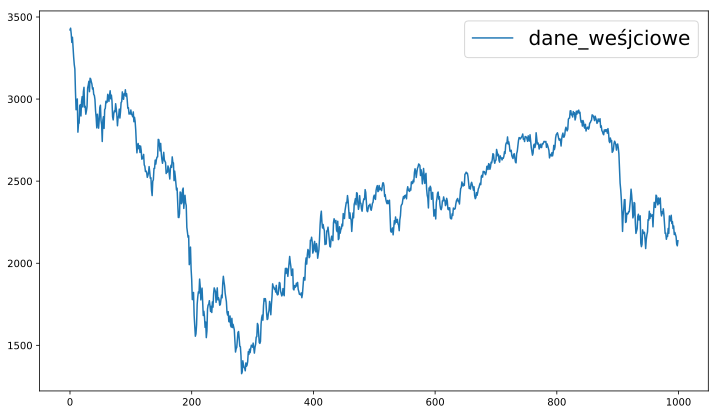

In [17]:
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('pdf', 'svg')

plt.rcParams['figure.figsize'] = [12, 7]
plt.plot(col,label=r'dane_weśjciowe')#blue
plt.legend(loc='best', fontsize=20)
plt.show()

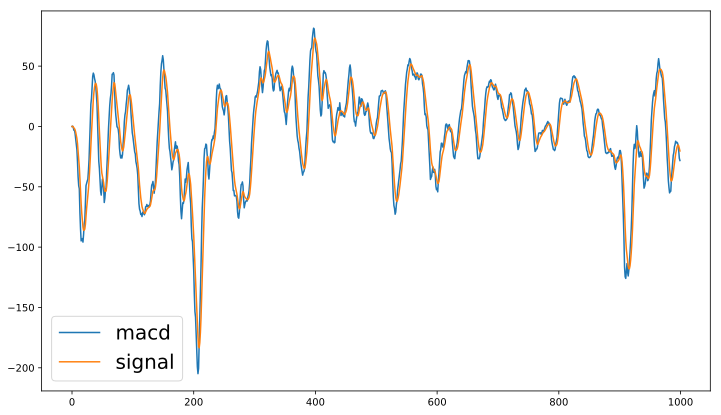

In [18]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 7]
plt.plot(macd,label=r'macd')#blue
plt.plot(signal,label=r'signal')#orange
plt.legend(loc='best', fontsize=20)
plt.show()


Wskaźnik MACD może być przydatny do wykorzystania w czasie gry na giełdzie. Widać to już na początku wybranego okresu, pierwsze przecięcie MACD z SIGNAL nastepuję od dołu co jest sygnałem do kupna akcji. Słusznośc tej decyzji potwierdza wykres danych wejściowych gdzie w tym samym momencie cena akcji przeżyła duży spadek w ostatnich dniach. Na pierwszy rzut oka wydaje się więc, że wkaźnik jest przydatny, jednak czy na jego podstawie da się napisać algorytm który przyniesie zyski?

# Algorytm gry na giełdzie nr 1

Poniższy algorytm działa zgodnie z zasadami wskaźnika MACD z małą modyfikacją. Dokonuje on kupna 10 akcji (można to modyfikować w poprzez zmienną stock) w momencie gdy wykres MACD przecina SIGNAL od dołu a sprzedaje wszystkie akcje (ich liczba przechowywana jest w zmiennej stock_sum) gdy MACD przecina SIGNAL od góry. Wszystko to dzieje się pod warunkiem, że MACD jest w i-tym dniu większę od 0.

In [19]:

wallet_list1 = []

def play1(data, wallet, macd, signal):
    stock = 10
    stock_sum = 0
    diff = macd[1] - signal[1]
    macdup = False
    if diff > 0:
        macdup = True
    
    wallet_list1.append(wallet)
    
    for i in range(2,1000):
        if macd[i] > 0:
            if macdup and diff < 0:
                macdup = False
                wallet += data[i]*stock_sum
                stock_sum = 0
                wallet_list1.append(wallet)
            elif macdup == False and diff > 0:
                macdup = True
                wallet -= data[i]*stock
                stock_sum += stock
                wallet_list1.append(wallet)
            if i !=999:
                diff = macd[i + 1] - signal[i + 1]
        
    return wallet + stock_sum*data[999]



## Wywołanie algorytmu nr 1 dla początkowej zawartości portfela 100 000:

In [20]:
wallet_start = 100000.00

wallet = play1(col,wallet_start,macd,signal)

wallet_list1.append(wallet)


## Wykres zawartości portfela dla po kolejnych działaniach algorytmu nr 1 na giełdzie:

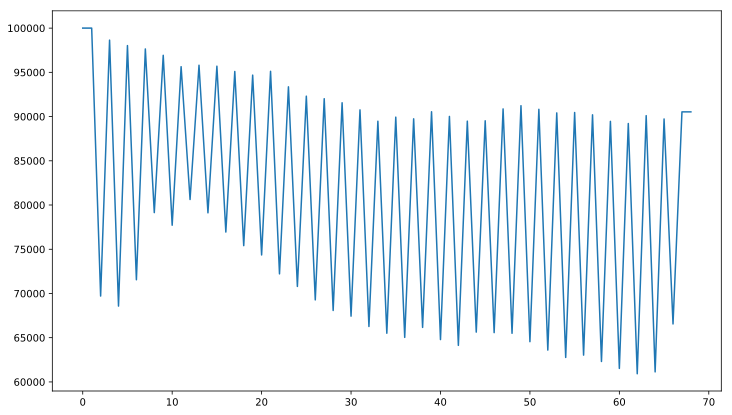

In [21]:

plt.rcParams['figure.figsize'] = [12, 7]
plt.plot(wallet_list1)#blue
plt.show()

## Zysk procentowy algorytmu nr 1 po 1000 dniach

In [22]:
print("Zysk procentowy wyniósł:")
print((wallet - wallet_start)/wallet_start*100, "%")

Zysk procentowy wyniósł:
-9.469899999999935 %


## Wykres zysku w procentach po kolejnych działaniach na giełdzie algorytmu nr 1

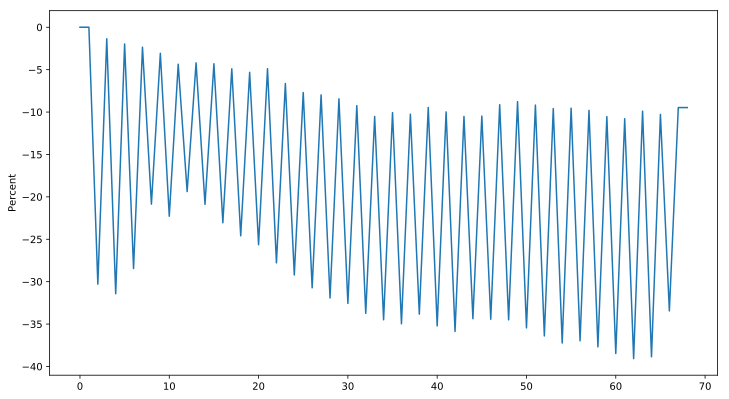

In [23]:

wallet_percent1 = []
for i in range(0,len(wallet_list1)):
    wallet_percent1.append((wallet_list1[i] - wallet_start)/wallet_start*100)
    
plt.rcParams['figure.figsize'] = [12, 7]
fig = plt.figure()
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_ylabel('Percent')
ax.plot(wallet_percent1)
plt.show()

# Algorytm gry na giełdzie nr 2

Drugi algorytm działa odwrotnie do algorytmu nr 1. Dokonuje on kupna 10 akcji  w momencie gdy wykres MACD przecina SIGNAL od góry a sprzedaje wszystkie akcje gdy MACD przecina SIGNAL od dołu.

In [24]:
wallet_list2 = []

def play2(data, wallet, macd, signal):
    stock = 10
    stock_sum = 0
    diff = macd[1] - signal[1]
    macdup = False
    if diff > 0:
        macdup = True
    
    wallet_list2.append(wallet)

    for i in range(2,1000):
            if macdup and diff < 0:
                macdup = False
                wallet -= data[i]*stock
                stock_sum += stock
                wallet_list2.append(wallet)
            elif macdup == False and diff > 0:
                macdup = True
                wallet += data[i]*stock_sum
                stock_sum = 0
                wallet_list2.append(wallet)
            if i != 999:
                diff = macd[i + 1] - signal[i + 1]

    return wallet + stock_sum*data[999]

## Wywołanie algortmu nr 2 dla początkowej zawartości portfela 100 000:

In [25]:
wallet_start = 100000.00

wallet = play2(col,wallet_start,macd,signal)

wallet_list2.append(wallet)

## Wykres zawartości portfela dla po kolejnych działaniach algorytmu nr 2 na giełdzie:

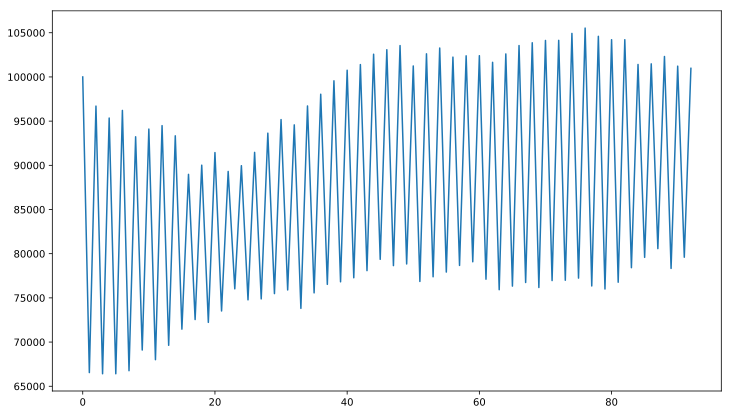

In [26]:
plt.rcParams['figure.figsize'] = [12, 7]
plt.plot(wallet_list2)#blue
plt.show()

## Zysk procentowy algorytmu nr 2 po 1000 dniach

In [27]:
print("Zysk procentowy wyniósł:")
print((wallet - wallet_start)/wallet_start*100, "%")

Zysk procentowy wyniósł:
0.9750999999999331 %


## Wykres zysku w procentach po kolejnych działaniach na giełdzie algorytmu nr 2

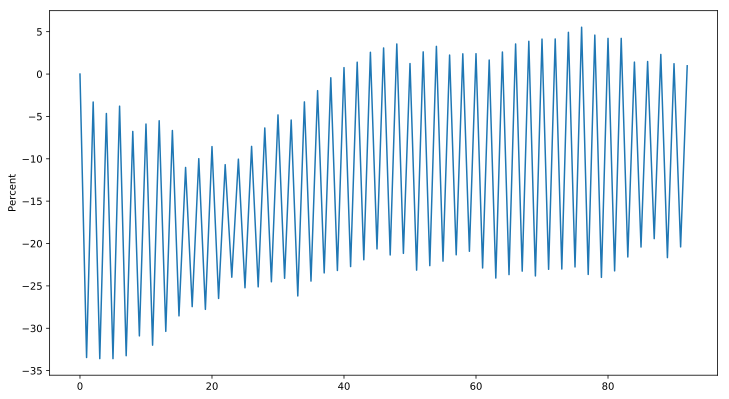

In [28]:
wallet_percent2 = []
for i in range(0,len(wallet_list2)):
    wallet_percent2.append((wallet_list2[i] - wallet_start)/wallet_start*100)
    
plt.rcParams['figure.figsize'] = [12, 7]
fig = plt.figure()
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_ylabel('Percent')
ax.plot(wallet_percent2)
plt.show()

# Wnioski
Co zaskakujące okazało się, że dla algorytmu niezgodnego z zasadami działania wskaźnika MACD (algorytm nr 2) wyniki okazały się lepsze, algorytm przyniósł zyski. Oczywiście nie można tego przyjmować za pewnik ponieważ algorytm mógłby dać inne wyniki dla innych danych. Warto również zaznaczyć, że tego typu symulacje mają mało wspólnego z prawdziwą grą na giełdzie ponieważ gdy dokonujemy pewnych działań na giełdzie (kupno, sprzedarz) sami wpływamy na ceny akcji, co nie może zostać uwzględnione w takiej symulacji. Podsumowując wykorzystanie wskaźnika MACD nie może dać 100% pewności zysku ponieważ nie uwzględnia on nieprzewidzianych wydarzeń, które wpływają na giełde.